In [1]:
# Common
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data 
# import cv2 as cv
from glob import glob
# from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Data Augmentation
from keras.models import Sequential
from keras.layers import Input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast

# Model Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model 
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D as GAP, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.applications import ResNet50, ResNet152, ResNet50V2, ResNet152V2, InceptionV3, MobileNet

2023-02-09 15:44:41.441340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-09 15:44:41.441425: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/home/mike/Downloads/archive(30)/Insect Classes/Insect Classes",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.


2023-02-09 15:31:41.439418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-09 15:31:41.439464: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-09 15:31:41.439518: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mike-HP-EliteBook-Folio-9470m): /proc/driver/nvidia/version does not exist


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "/home/mike/Downloads/archive(30)/Insect Classes/Insect Classes",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 10 classes.
Using 2000 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Bees', 'Beetles', 'Butterfly', 'Cicada', 'Dragonfly', 'Grasshopper', 'Moth', 'Scorpion', 'Snail', 'Spider']


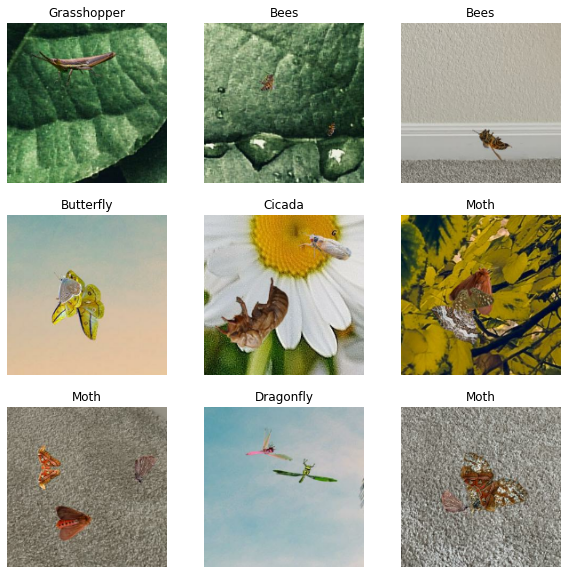

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
num_classes = 10

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


2023-02-09 15:34:15.013009: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 129777664 exceeds 10% of free system memory.
2023-02-09 15:34:15.832267: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32444416 exceeds 10% of free system memory.
2023-02-09 15:34:15.908694: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31002624 exceeds 10% of free system memory.
2023-02-09 15:34:16.562383: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29047680 exceeds 10% of free system memory.
2023-02-09 15:34:16.656943: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31002624 exceeds 10% of free system memory.


250/250 [==============================] - 392s 2s/step - loss: 2.2445 - accuracy: 0.1460 - val_loss: 2.1594 - val_accuracy: 0.1915
Epoch 2/3
  8/250 [..............................] - ETA: 1:21:17 - loss: 2.1772 - accuracy: 0.1875